In [2]:
import requests
import pandas as pd
import time

API_KEY = 'be1d54fcf233912cf9ded5f7eaba4959'
BASE_URL = 'https://api.themoviedb.org/3'

def fetch_movie_data(years=[2023, 2024]):
    all_movies = []

    for year in years:
        # 1. Discover movies for a specific year, sorted by revenue
        discover_url = f"{BASE_URL}/discover/movie"
        params = {
            'api_key': API_KEY,
            'primary_release_year': year,
            'sort_by': 'revenue.desc',
            'page': range(1,20) # You can loop through multiple pages
        }

        response = requests.get(discover_url, params=params).json()

        for movie in response.get('results', []):
            m_id = movie['id']

            # 2. Get full details to find 'belongs_to_collection'
            detail_url = f"{BASE_URL}/movie/{m_id}"
            detail_params = {'api_key': API_KEY}
            m_details = requests.get(detail_url, params=detail_params).json()

            # 3. Tag as Franchise or Original
            is_franchise = m_details.get('belongs_to_collection') is not None

            all_movies.append({
                'title': m_details.get('title'),
                'year': year,
                'budget': m_details.get('budget'),
                'revenue': m_details.get('revenue'),
                'is_franchise': is_franchise,
                'genres': [g['name'] for g in m_details.get('genres', [])]
            })

            # Respect rate limits
            #time.sleep(0.1)

    return pd.DataFrame(all_movies)

# Example usage
# df = fetch_movie_data(years=range(2004, 2025))

In [9]:
df = fetch_movie_data(years=range(2004, 2025))

In [10]:
df


,title,year,budget,revenue,is_franchise,genres
0,The Terminal,2004,60000000,219417255,False,"[Comedy, Drama]"
1,Million Dollar Baby,2004,30000000,216763646,False,[Drama]
2,The Aviator,2004,110000000,213719942,False,[Drama]
3,Lemony Snicket's A Series of Unfortunate Events,2004,140000000,209073645,False,"[Adventure, Comedy, Family]"
4,King Arthur,2004,120000000,203567857,False,"[Adventure, War, History, Action, Drama]"
...,...,...,...,...,...,...
415,Nosferatu,2024,50000000,181764515,False,"[Horror, Fantasy]"
416,The Fall Guy,2024,125000000,181073291,False,"[Action, Comedy, Romance]"
417,Bob Marley: One Love,2024,70000000,180828556,False,"[Music, History, Drama]"
418,Furiosa: A Mad Max Saga,2024,168000000,174287546,True,"[Action, Science Fiction, Adventure]"


In [11]:
df.describe()

,year,budget,revenue
count,420.000000,4.200000e+02,4.200000e+02
mean,2014.000000,7.105657e+07,2.265612e+08
std,6.062522,5.346714e+07,7.804613e+07
min,2004.000000,0.000000e+00,3.576232e+07
25%,2009.000000,3.000000e+07,1.744024e+08
50%,2014.000000,6.250000e+07,2.192518e+08
75%,2019.000000,1.000000e+08,2.760120e+08
max,2024.000000,2.748000e+08,4.590661e+08


In [15]:
df.shape
!pip install tqdm

zsh:1: command not found: pip


In [35]:
import requests
import pandas as pd
import time

# --- CONFIGURATION ---
API_KEY = 'be1d54fcf233912cf9ded5f7eaba4959'
BASE_URL = 'https://api.themoviedb.org/3'
YEARS = range(2005, 2025)
PAGES_PER_YEAR = 20

def pull_everything_simple():
    raw_responses = []

    for year in YEARS:
        print(f"\n--- Starting Year: {year} ---")

        for page in range(1, PAGES_PER_YEAR + 1):
            print(f"Fetching Year {year}, Page {page}...")

            # 1. Discover movies to get their IDs
            discover_url = f"{BASE_URL}/discover/movie"
            params = {
                'api_key': API_KEY,
                'primary_release_year': year,
                'sort_by': 'popularity.desc',
                'page': page
            }

            try:
                discover_resp = requests.get(discover_url, params=params).json()
                movie_list = discover_resp.get('results', [])

                for index, m in enumerate(movie_list):
                    m_id = m['id']

                    # 2. Pull the FULL detail object for this movie
                    # 'append_to_response' ensures we get keywords and credits columns too
                    detail_url = f"{BASE_URL}/movie/{m_id}"
                    detail_params = {
                        'api_key': API_KEY,
                        'append_to_response': 'keywords,credits'
                    }

                    full_movie_data = requests.get(detail_url, params=detail_params).json()

                    # Store the entire raw dictionary
                    raw_responses.append(full_movie_data)

                    # Simple status update every 5 movies
                    if index % 10 == 0:
                        print(f"  Processed {index}/{len(movie_list)} movies on this page...")

                    # Essential delay to prevent being blocked by TMDb
                    #time.sleep(0.05)

            except Exception as e:
                print(f"  Error on Year {year}, Page {page}: {e}")

    # 3. Flatten the JSON structure into a wide table
    print("\nFlattening data and converting to CSV...")
    df = pd.json_normalize(raw_responses)

    # Save to CSV
    filename = 'datav2.csv'
    df.to_csv(filename, index=False)
    print(f"Success! Saved {len(df)} movies with {len(df.columns)} columns to {filename}")

    return df

# To run the script, uncomment the line below:
# df = pull_everything_simple()

In [36]:
df = pull_everything_simple()


--- Starting Year: 2005 ---
Fetching Year 2005, Page 1...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 2...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 3...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 4...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 5...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 6...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 7...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 8...
  Processed 0/20 movies on this page...
  Processed 10/20 movies on this page...
Fetching Year 2005, Page 9...
  Processed 0/20 movies on this page...
  Processed 1

In [127]:
df

,backdrop_path,budget,homepage,id,imdb_id,origin_country,original_language,original_title,overview,popularity,...,belongs_to_collection.name,belongs_to_collection.poster_path,belongs_to_collection.backdrop_path,year,month,dow,genre_count,log_budget,log_revenue,roi
0,NaN,NaN,NaN,1012149,tt0466067,['JP'],ja,メノット,NaN,11.2729,...,NaN,NaN,NaN,2005,7,5,1,NaN,NaN,NaN
1,/8f9dnOtpArDrOMEylpSN9Sc6fuz.jpg,150000000.0,https://www.warnerbros.com/movies/harry-potter...,674,tt0330373,['GB'],en,Harry Potter and the Goblet of Fire,When Harry Potter's name emerges from the Gobl...,21.5325,...,Harry Potter Collection,/eVPs2Y0LyvTLZn6AP5Z6O2rtiGB.jpg,/kmEsQL2vOTA0jnM28fXS45Ky8kX.jpg,2005,11,2,2,18.826146,20.613363,5.972807
2,/tuDhEdza074bA497bO9WFEPs6O6.jpg,180000000.0,NaN,411,tt0363771,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...","Siblings Lucy, Edmund, Susan and Peter step th...",19.2598,...,The Chronicles of Narnia Collection,/sh6Kn8VBfXotJ6qsvJkdfscxXKR.jpg,/ojjzZUQlqKTsN1T7s5OAVZSjYMH.jpg,2005,12,2,3,19.008467,20.428912,4.138962
3,/tPaurpIUskVji5vwV0dhy9pq4Vs.jpg,75000000.0,https://www.dreamworks.com/movies/madagascar,953,tt0351283,['US'],en,Madagascar,Four animal friends get a taste of the wild li...,14.6773,...,Madagascar Collection,/UXIxsUbwMpv4v8xXRdT7LX58z9.jpg,/lzTIAbvMeGWB7PUrmBZXulGA28M.jpg,2005,5,2,4,18.132999,20.110896,7.227527
4,/AfgW0A1bJ0FortWTds5TR8nZ2vl.jpg,NaN,NaN,55009,tt0465537,['US'],en,Mayday,"Twelve miles above the Pacific Ocean, an erran...",14.7410,...,NaN,NaN,NaN,2005,10,6,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,/fig3yqoRHaVfe6Tv5b9JUOAQ2BU.jpg,NaN,https://www.palaceletters.com,1230488,tt29224906,['AU'],en,The Search for the Palace Letters,This remarkable documentary tells the story of...,4.9772,...,NaN,NaN,NaN,2024,1,0,1,NaN,NaN,NaN
7951,/3M7915sC39DbQHP60XuRNyVkgsY.jpg,NaN,https://www.spoon-inc.co.jp/at-the-bench/,1370709,tt33477504,['JP'],ja,アット・ザ・ベンチ,In the middle of a riverside park stands a sin...,6.3324,...,NaN,NaN,NaN,2024,11,4,2,NaN,NaN,NaN
7952,/mO2s5z2iWiLpCM67q6NQgYC8COC.jpg,NaN,NaN,1273207,tt32138754,['CN'],zh,负负得正,"Kai, a reclusive young man who believes he's b...",5.9826,...,NaN,NaN,NaN,2024,8,5,2,NaN,16.118593,NaN
7953,NaN,NaN,NaN,1377390,tt30447133,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,"Hari, a government employee, lives with his wi...",6.6166,...,NaN,NaN,NaN,2024,12,5,2,NaN,NaN,NaN


In [38]:
df.shape


(8000, 33)

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [45]:
%matplotlib inline
from io import StringIO
plt.rcParams["figure.figsize"] = (8,4)


# 2. Load Dataset (robust fallback)
try:
    df = pd.read_csv("datav2.csv")
except:

    raw = open("datav2.csv", "rb").read().decode("utf-8", errors="replace")
    df = pd.read_csv(StringIO(raw), engine="python", on_bad_lines="skip")

In [46]:
print(df.shape)
print(df.columns.tolist())
df.info()
df.isnull().sum().sort_values(ascending=False).head(20)

(7955, 33)
['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'origin_country', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'keywords.keywords', 'credits.cast', 'credits.crew', 'belongs_to_collection.id', 'belongs_to_collection.name', 'belongs_to_collection.poster_path', 'belongs_to_collection.backdrop_path']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   adult                                7955 non-null   bool   
 1   backdrop_path                        6416 non-null   object 
 2   belongs_to_collection                0 non-null     

belongs_to_collection                  7955
belongs_to_collection.backdrop_path    7045
belongs_to_collection.poster_path      6848
belongs_to_collection.id               6715
belongs_to_collection.name             6715
homepage                               5741
tagline                                5144
backdrop_path                          1539
imdb_id                                1051
overview                                313
poster_path                             195
credits.crew                              0
status                                    0
keywords.keywords                         0
vote_count                                0
vote_average                              0
video                                     0
title                                     0
credits.cast                              0
adult                                     0
dtype: int64

In [48]:
def fix_num(c): return pd.to_numeric(df[c], errors="coerce")
for col in ["budget", "revenue", "popularity", "runtime", "vote_average", "vote_count"]:
    if col in df: df[col] = fix_num(col)

In [49]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df["month"] = df["release_date"].dt.month
df["dow"] = df["release_date"].dt.dayofweek

In [50]:
import ast, json


def parse_list(x):
    try:
        val = ast.literal_eval(str(x))
        if isinstance(val, list): return [i["name"] if isinstance(i, dict) and "name" in i else str(i) for i in val]
    except: return []
df["genres"] = df["genres"].map(parse_list)
df["genre_count"] = df["genres"].map(len)

In [53]:
'''df = df[df["runtime"] < 10000]
df = df.drop_duplicates()
df.loc[df["budget"] == 0, "budget"] = np.nan
df.loc[df["revenue"] == 0, "revenue"] = np.nan'''

'df = df[df["runtime"] < 10000]\ndf = df.drop_duplicates()\ndf.loc[df["budget"] == 0, "budget"] = np.nan\ndf.loc[df["revenue"] == 0, "revenue"] = np.nan'

In [60]:
def fix_num(c): return pd.to_numeric(df[c], errors="coerce")
for col in ["budget", "revenue", "popularity", "runtime", "vote_average", "vote_count"]:
    if col in df: df[col] = fix_num(col)


df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df["month"] = df["release_date"].dt.month
df["dow"] = df["release_date"].dt.dayofweek
df

,adult,backdrop_path,belongs_to_collection,budget,homepage,id,imdb_id,origin_country,original_language,original_title,...,credits.cast,credits.crew,belongs_to_collection.id,belongs_to_collection.name,belongs_to_collection.poster_path,belongs_to_collection.backdrop_path,year,month,dow,genre_count
0,False,NaN,NaN,NaN,NaN,1012149,tt0466067,['JP'],ja,メノット,...,"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",NaN,NaN,NaN,NaN,2005,7,5,1
1,False,/8f9dnOtpArDrOMEylpSN9Sc6fuz.jpg,NaN,150000000.0,https://www.warnerbros.com/movies/harry-potter...,674,tt0330373,['GB'],en,Harry Potter and the Goblet of Fire,...,"[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",1241.0,Harry Potter Collection,/eVPs2Y0LyvTLZn6AP5Z6O2rtiGB.jpg,/kmEsQL2vOTA0jnM28fXS45Ky8kX.jpg,2005,11,2,2
2,False,/tuDhEdza074bA497bO9WFEPs6O6.jpg,NaN,180000000.0,NaN,411,tt0363771,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",...,"[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",420.0,The Chronicles of Narnia Collection,/sh6Kn8VBfXotJ6qsvJkdfscxXKR.jpg,/ojjzZUQlqKTsN1T7s5OAVZSjYMH.jpg,2005,12,2,3
3,False,/tPaurpIUskVji5vwV0dhy9pq4Vs.jpg,NaN,75000000.0,https://www.dreamworks.com/movies/madagascar,953,tt0351283,['US'],en,Madagascar,...,"[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",14740.0,Madagascar Collection,/UXIxsUbwMpv4v8xXRdT7LX58z9.jpg,/lzTIAbvMeGWB7PUrmBZXulGA28M.jpg,2005,5,2,4
4,False,/AfgW0A1bJ0FortWTds5TR8nZ2vl.jpg,NaN,NaN,NaN,55009,tt0465537,['US'],en,Mayday,...,"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",NaN,NaN,NaN,NaN,2005,10,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,False,/fig3yqoRHaVfe6Tv5b9JUOAQ2BU.jpg,NaN,NaN,https://www.palaceletters.com,1230488,tt29224906,['AU'],en,The Search for the Palace Letters,...,"[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",NaN,NaN,NaN,NaN,2024,1,0,1
7951,False,/3M7915sC39DbQHP60XuRNyVkgsY.jpg,NaN,NaN,https://www.spoon-inc.co.jp/at-the-bench/,1370709,tt33477504,['JP'],ja,アット・ザ・ベンチ,...,"[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",NaN,NaN,NaN,NaN,2024,11,4,2
7952,False,/mO2s5z2iWiLpCM67q6NQgYC8COC.jpg,NaN,NaN,NaN,1273207,tt32138754,['CN'],zh,负负得正,...,"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",NaN,NaN,NaN,NaN,2024,8,5,2
7953,False,NaN,NaN,NaN,NaN,1377390,tt30447133,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,...,"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",NaN,NaN,NaN,NaN,2024,12,5,2


In [69]:
import ast, json


def parse_list(x):
    try:
        val = ast.literal_eval(str(x))
        if isinstance(val, list): return [i["name"] if isinstance(i, dict) and "name" in i else str(i) for i in val]
    except: return []
if "genres" in df.columns:
    df["genres"] = df["genres"].map(parse_list)
if "genres" in df.columns:
    df["genre_count"] = df["genres"].map(len)
df

,adult,backdrop_path,belongs_to_collection,budget,homepage,id,imdb_id,origin_country,original_language,original_title,...,credits.cast,credits.crew,belongs_to_collection.id,belongs_to_collection.name,belongs_to_collection.poster_path,belongs_to_collection.backdrop_path,year,month,dow,genre_count
0,False,NaN,NaN,NaN,NaN,1012149,tt0466067,['JP'],ja,メノット,...,"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",NaN,NaN,NaN,NaN,2005,7,5,1
1,False,/8f9dnOtpArDrOMEylpSN9Sc6fuz.jpg,NaN,150000000.0,https://www.warnerbros.com/movies/harry-potter...,674,tt0330373,['GB'],en,Harry Potter and the Goblet of Fire,...,"[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",1241.0,Harry Potter Collection,/eVPs2Y0LyvTLZn6AP5Z6O2rtiGB.jpg,/kmEsQL2vOTA0jnM28fXS45Ky8kX.jpg,2005,11,2,2
2,False,/tuDhEdza074bA497bO9WFEPs6O6.jpg,NaN,180000000.0,NaN,411,tt0363771,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",...,"[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",420.0,The Chronicles of Narnia Collection,/sh6Kn8VBfXotJ6qsvJkdfscxXKR.jpg,/ojjzZUQlqKTsN1T7s5OAVZSjYMH.jpg,2005,12,2,3
3,False,/tPaurpIUskVji5vwV0dhy9pq4Vs.jpg,NaN,75000000.0,https://www.dreamworks.com/movies/madagascar,953,tt0351283,['US'],en,Madagascar,...,"[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",14740.0,Madagascar Collection,/UXIxsUbwMpv4v8xXRdT7LX58z9.jpg,/lzTIAbvMeGWB7PUrmBZXulGA28M.jpg,2005,5,2,4
4,False,/AfgW0A1bJ0FortWTds5TR8nZ2vl.jpg,NaN,NaN,NaN,55009,tt0465537,['US'],en,Mayday,...,"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",NaN,NaN,NaN,NaN,2005,10,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,False,/fig3yqoRHaVfe6Tv5b9JUOAQ2BU.jpg,NaN,NaN,https://www.palaceletters.com,1230488,tt29224906,['AU'],en,The Search for the Palace Letters,...,"[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",NaN,NaN,NaN,NaN,2024,1,0,1
7951,False,/3M7915sC39DbQHP60XuRNyVkgsY.jpg,NaN,NaN,https://www.spoon-inc.co.jp/at-the-bench/,1370709,tt33477504,['JP'],ja,アット・ザ・ベンチ,...,"[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",NaN,NaN,NaN,NaN,2024,11,4,2
7952,False,/mO2s5z2iWiLpCM67q6NQgYC8COC.jpg,NaN,NaN,NaN,1273207,tt32138754,['CN'],zh,负负得正,...,"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",NaN,NaN,NaN,NaN,2024,8,5,2
7953,False,NaN,NaN,NaN,NaN,1377390,tt30447133,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,...,"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",NaN,NaN,NaN,NaN,2024,12,5,2


In [128]:
f = df[df["runtime"] < 10000]
df = df.drop(columns=["genres",'belongs_to_collection','video','adult','backdrop_path','homepage','id','imdb_id','overview','poster_path','status','tagline','belongs_to_collection.id','belongs_to_collection.backdrop_path','belongs_to_collection.name','belongs_to_collection.poster_path'], errors="ignore")
df = df.drop_duplicates()
df.loc[df["budget"] == 0, "budget"] = np.nan
df.loc[df["revenue"] == 0, "revenue"] = np.nan


In [129]:
df


,budget,origin_country,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,...,keywords.keywords,credits.cast,credits.crew,year,month,dow,genre_count,log_budget,log_revenue,roi
0,NaN,['JP'],ja,メノット,11.2729,"[{'id': 15631, 'logo_path': '/x7Mw2IPYOAiFtuce...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,...,[],"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",2005,7,5,1,NaN,NaN,NaN
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'id': 174, 'logo_path': '/ingPVoHnINIrFR7WHm...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,...,"[{'id': 616, 'name': 'witch'}, {'id': 3737, 'n...","[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",2005,11,2,2,18.826146,20.613363,5.972807
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,...,"[{'id': 616, 'name': 'witch'}, {'id': 380, 'na...","[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",2005,12,2,3,19.008467,20.428912,4.138962
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'id': 520, 'logo_path': '/pU7YTI9FfrICurXpl5...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,...,"[{'id': 6054, 'name': 'friendship'}, {'id': 20...","[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",2005,5,2,4,18.132999,20.110896,7.227527
4,NaN,['US'],en,Mayday,14.7410,"[{'id': 79077, 'logo_path': None, 'name': 'The...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,...,[],"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",2005,10,6,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,"[{'id': 137929, 'logo_path': None, 'name': 'Fi...","[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2024-01-08,NaN,59,...,"[{'id': 3344, 'name': 'letter'}, {'id': 12408,...","[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",2024,1,0,1,NaN,NaN,NaN
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,"[{'id': 199398, 'logo_path': '/Q6fnWCZTEw6x2hO...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2024-11-15,NaN,86,...,"[{'id': 9706, 'name': 'anthology'}]","[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",2024,11,4,2,NaN,NaN,NaN
7952,NaN,['CN'],zh,负负得正,5.9826,"[{'id': 197030, 'logo_path': '/z9xtT1e3HunOnZU...","[{'iso_3166_1': 'CN', 'name': 'China'}]",2024-08-10,10004977.0,100,...,[],"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",2024,8,5,2,NaN,16.118593,NaN
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,"[{'id': 273941, 'logo_path': None, 'name': 'Na...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2024-12-14,NaN,90,...,[],"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",2024,12,5,2,NaN,NaN,NaN


In [101]:
df["log_budget"] = np.log1p(df["budget"])
df["log_revenue"] = np.log1p(df["revenue"])
df["roi"] = df["revenue"] / df["budget"]
df["roi"] = df["roi"].where(df["budget"] > 0)

In [130]:
df

,budget,origin_country,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,...,keywords.keywords,credits.cast,credits.crew,year,month,dow,genre_count,log_budget,log_revenue,roi
0,NaN,['JP'],ja,メノット,11.2729,"[{'id': 15631, 'logo_path': '/x7Mw2IPYOAiFtuce...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,...,[],"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",2005,7,5,1,NaN,NaN,NaN
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'id': 174, 'logo_path': '/ingPVoHnINIrFR7WHm...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,...,"[{'id': 616, 'name': 'witch'}, {'id': 3737, 'n...","[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",2005,11,2,2,18.826146,20.613363,5.972807
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,...,"[{'id': 616, 'name': 'witch'}, {'id': 380, 'na...","[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",2005,12,2,3,19.008467,20.428912,4.138962
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'id': 520, 'logo_path': '/pU7YTI9FfrICurXpl5...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,...,"[{'id': 6054, 'name': 'friendship'}, {'id': 20...","[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",2005,5,2,4,18.132999,20.110896,7.227527
4,NaN,['US'],en,Mayday,14.7410,"[{'id': 79077, 'logo_path': None, 'name': 'The...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,...,[],"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",2005,10,6,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,"[{'id': 137929, 'logo_path': None, 'name': 'Fi...","[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2024-01-08,NaN,59,...,"[{'id': 3344, 'name': 'letter'}, {'id': 12408,...","[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",2024,1,0,1,NaN,NaN,NaN
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,"[{'id': 199398, 'logo_path': '/Q6fnWCZTEw6x2hO...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2024-11-15,NaN,86,...,"[{'id': 9706, 'name': 'anthology'}]","[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",2024,11,4,2,NaN,NaN,NaN
7952,NaN,['CN'],zh,负负得正,5.9826,"[{'id': 197030, 'logo_path': '/z9xtT1e3HunOnZU...","[{'iso_3166_1': 'CN', 'name': 'China'}]",2024-08-10,10004977.0,100,...,[],"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",2024,8,5,2,NaN,16.118593,NaN
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,"[{'id': 273941, 'logo_path': None, 'name': 'Na...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2024-12-14,NaN,90,...,[],"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",2024,12,5,2,NaN,NaN,NaN


In [131]:
df.shape

(7649, 24)

In [132]:
df.describe()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,year,month,dow,genre_count,log_budget,log_revenue,roi
count,1.568000e+03,7649.000000,7649,1.793000e+03,7649.000000,7649.000000,7649.000000,7649.000000,7649.000000,7649.000000,7649.000000,1568.000000,1793.000000,1243.000000
mean,5.167563e+07,6.866853,2014-12-12 15:01:45.896195584,1.591417e+08,96.397699,4.997515,894.925742,2014.432344,6.725062,3.330370,2.029285,16.317955,16.839744,6.979469
min,3.000000e+00,3.417000,2005-01-01 00:00:00,1.000000e+00,0.000000,0.000000,0.000000,2005.000000,1.000000,0.000000,0.000000,1.386294,0.693147,0.000083
25%,4.200000e+06,5.837700,2009-11-04 00:00:00,4.500000e+06,86.000000,4.000000,1.000000,2009.000000,4.000000,2.000000,1.000000,15.250595,15.319588,1.396817
50%,2.000000e+07,6.351400,2014-10-26 00:00:00,3.516492e+07,100.000000,6.000000,11.000000,2014.000000,7.000000,3.000000,2.000000,16.811243,17.375560,2.780000
75%,7.825000e+07,6.981000,2020-01-01 00:00:00,2.022314e+08,118.000000,6.880000,73.000000,2020.000000,10.000000,4.000000,3.000000,18.175404,19.124923,4.812530
max,5.839000e+08,276.196200,2024-12-30 00:00:00,2.353096e+09,600.000000,10.000000,35052.000000,2024.000000,12.000000,6.000000,8.000000,20.185240,21.578998,1528.112245
std,6.795703e+07,4.109280,NaN,2.659594e+08,38.391421,2.661492,2953.912594,5.810614,3.472298,1.454243,1.157647,2.609200,2.963266,50.907665


In [133]:
"""df["log_budget"].hist(bins=50)
plt.title("Log Budget"); plt.show()"""
fig1 = px.histogram(df, x="log_budget", nbins=100, title="Log Budget")
fig1.show()

In [134]:
"""df["log_revenue"].hist(bins=50,)
plt.title("Log Revenue"); plt.show()"""

fig2 = px.histogram(df, x="log_revenue", nbins=100, title="Log Revenue")
fig2.show()

In [135]:
"""plt.scatter(df["log_budget"], df["log_revenue"], alpha=0.5)
plt.title("Budget vs Revenue (log)")
plt.xlabel("log(budget)"); plt.ylabel("log(revenue)")
plt.show()"""

fig3 = px.scatter(df, x="log_budget", y="log_revenue", opacity=0.5,
            title="Budget vs Revenue (log scale)",
            labels={"log_budget": "Log(Budget)", "log_revenue": "Log(Revenue)"})
fig3.show()

In [136]:
cols = ["budget", "revenue", "runtime", "popularity", "vote_average", "vote_count", "roi"]
corr = df[cols].corr()
fig4 = px.imshow(corr, text_auto=True, color_continuous_scale="RdBu_r",
title="Correlation Matrix")
fig4.show()

In [137]:
px.scatter(df, x="budget", y="revenue", log_x=True, log_y=True, hover_name="title").show()

In [138]:
df.to_csv("movies_cleaned.csv", index=False)
print("Saved cleaned dataset.")

Saved cleaned dataset.


In [140]:
df.head(5)

,budget,origin_country,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,...,keywords.keywords,credits.cast,credits.crew,year,month,dow,genre_count,log_budget,log_revenue,roi
0,NaN,['JP'],ja,メノット,11.2729,"[{'id': 15631, 'logo_path': '/x7Mw2IPYOAiFtuce...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,...,[],"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",2005,7,5,1,NaN,NaN,NaN
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'id': 174, 'logo_path': '/ingPVoHnINIrFR7WHm...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,...,"[{'id': 616, 'name': 'witch'}, {'id': 3737, 'n...","[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",2005,11,2,2,18.826146,20.613363,5.972807
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,...,"[{'id': 616, 'name': 'witch'}, {'id': 380, 'na...","[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",2005,12,2,3,19.008467,20.428912,4.138962
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'id': 520, 'logo_path': '/pU7YTI9FfrICurXpl5...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,...,"[{'id': 6054, 'name': 'friendship'}, {'id': 20...","[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",2005,5,2,4,18.132999,20.110896,7.227527
4,NaN,['US'],en,Mayday,14.7410,"[{'id': 79077, 'logo_path': None, 'name': 'The...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,...,[],"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",2005,10,6,2,NaN,NaN,NaN


In [141]:
df['production_company'] = (
    df['production_companies']
      .str.findall(r"'name':\s*'([^']+)'")
      .str[0]
)


In [142]:
df


,budget,origin_country,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,...,credits.cast,credits.crew,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company
0,NaN,['JP'],ja,メノット,11.2729,"[{'id': 15631, 'logo_path': '/x7Mw2IPYOAiFtuce...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,...,"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",2005,7,5,1,NaN,NaN,NaN,Active Cine Club
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'id': 174, 'logo_path': '/ingPVoHnINIrFR7WHm...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,...,"[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,...,"[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'id': 520, 'logo_path': '/pU7YTI9FfrICurXpl5...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,...,"[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images
4,NaN,['US'],en,Mayday,14.7410,"[{'id': 79077, 'logo_path': None, 'name': 'The...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,...,"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,"[{'id': 137929, 'logo_path': None, 'name': 'Fi...","[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2024-01-08,NaN,59,...,"[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",2024,1,0,1,NaN,NaN,NaN,Film Art Doco
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,"[{'id': 199398, 'logo_path': '/Q6fnWCZTEw6x2hO...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2024-11-15,NaN,86,...,"[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",2024,11,4,2,NaN,NaN,NaN,Spoon.
7952,NaN,['CN'],zh,负负得正,5.9826,"[{'id': 197030, 'logo_path': '/z9xtT1e3HunOnZU...","[{'iso_3166_1': 'CN', 'name': 'China'}]",2024-08-10,10004977.0,100,...,"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,"[{'id': 273941, 'logo_path': None, 'name': 'Na...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2024-12-14,NaN,90,...,"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production


In [143]:
df.drop(columns=['production_companies'], inplace=True)


In [144]:
df

,budget,origin_country,original_language,original_title,popularity,production_countries,release_date,revenue,runtime,spoken_languages,...,credits.cast,credits.crew,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company
0,NaN,['JP'],ja,メノット,11.2729,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",...,"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",2005,7,5,1,NaN,NaN,NaN,Active Cine Club
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images
4,NaN,['US'],en,Mayday,14.7410,"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,"[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2024-01-08,NaN,59,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",2024,1,0,1,NaN,NaN,NaN,Film Art Doco
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2024-11-15,NaN,86,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",...,"[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",2024,11,4,2,NaN,NaN,NaN,Spoon.
7952,NaN,['CN'],zh,负负得正,5.9826,"[{'iso_3166_1': 'CN', 'name': 'China'}]",2024-08-10,10004977.0,100,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",...,"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2024-12-14,NaN,90,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",...,"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production


In [145]:
df['production_company'] = df['production_company'].fillna('Others')


In [147]:
df

,budget,origin_country,original_language,original_title,popularity,production_countries,release_date,revenue,runtime,spoken_languages,...,credits.cast,credits.crew,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company
0,NaN,['JP'],ja,メノット,11.2729,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",...,"[{'adult': False, 'gender': 1, 'id': 149404, '...","[{'adult': False, 'gender': 2, 'id': 119335, '...",2005,7,5,1,NaN,NaN,NaN,Active Cine Club
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 10980, 'k...","[{'adult': False, 'gender': 2, 'id': 293, 'kno...",2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 5528, 'kn...","[{'adult': False, 'gender': 2, 'id': 5524, 'kn...",2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 7399, 'kn...","[{'adult': False, 'gender': 0, 'id': 1176124, ...",2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images
4,NaN,['US'],en,Mayday,14.7410,"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 2, 'id': 18992, 'k...","[{'adult': False, 'gender': 2, 'id': 20976, 'k...",2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,"[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2024-01-08,NaN,59,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,"[{'adult': False, 'gender': 1, 'id': 2843057, ...","[{'adult': False, 'gender': 0, 'id': 1371426, ...",2024,1,0,1,NaN,NaN,NaN,Film Art Doco
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2024-11-15,NaN,86,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",...,"[{'adult': False, 'gender': 1, 'id': 1454976, ...","[{'adult': False, 'gender': 2, 'id': 4301305, ...",2024,11,4,2,NaN,NaN,NaN,Spoon.
7952,NaN,['CN'],zh,负负得正,5.9826,"[{'iso_3166_1': 'CN', 'name': 'China'}]",2024-08-10,10004977.0,100,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",...,"[{'adult': False, 'gender': 2, 'id': 1743471, ...","[{'adult': False, 'gender': 2, 'id': 3074803, ...",2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2024-12-14,NaN,90,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",...,"[{'adult': False, 'gender': 2, 'id': 1569583, ...","[{'adult': False, 'gender': 0, 'id': 1992971, ...",2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production


In [148]:
df['original_name'] = (
    df['credits.cast']
      .str.findall(r"'original_name':\s*'([^']+)'")
      .str[0]
)


In [159]:
df['original_name'] = df['original_name'].fillna('others')


In [161]:
"""df.drop(columns=['credits.crew'], inplace=True)
"""

"df.drop(columns=['credits.crew'], inplace=True)\n"

In [164]:
df['production_country'] = (
    df['production_countries']
      .str.findall(r"'name':\s*'([^']+)'")
      .str[0]
)

In [165]:
df


,budget,origin_country,original_language,original_title,popularity,production_countries,release_date,revenue,runtime,spoken_languages,...,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country
0,NaN,['JP'],ja,メノット,11.2729,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2005-07-23,NaN,0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",...,2005,7,5,1,NaN,NaN,NaN,Active Cine Club,国分佐智子,Japan
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-11-16,895921036.0,157,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2005-12-07,745013115.0,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom
3,75000000.0,['US'],en,Madagascar,14.6773,"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-05-25,542064525.0,86,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America
4,NaN,['US'],en,Mayday,14.7410,"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-10-02,NaN,120,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company,Aidan Quinn,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,"[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2024-01-08,NaN,59,"[{'english_name': 'English', 'iso_639_1': 'en'...",...,2024,1,0,1,NaN,NaN,NaN,Film Art Doco,Jenny Hocking,Australia
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2024-11-15,NaN,86,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",...,2024,11,4,2,NaN,NaN,NaN,Spoon.,広瀬すず,Japan
7952,NaN,['CN'],zh,负负得正,5.9826,"[{'iso_3166_1': 'CN', 'name': 'China'}]",2024-08-10,10004977.0,100,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",...,2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao,朱一龙,China
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2024-12-14,NaN,90,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",...,2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production,Vishnu Unnikrishnan,India


In [166]:
df.drop(columns=['production_countries'], inplace=True)

In [167]:
df

,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,...,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country
0,NaN,['JP'],ja,メノット,11.2729,2005-07-23,NaN,0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Menotto,...,2005,7,5,1,NaN,NaN,NaN,Active Cine Club,国分佐智子,Japan
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036.0,157,"[{'english_name': 'English', 'iso_639_1': 'en'...",Harry Potter and the Goblet of Fire,...,2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115.0,143,"[{'english_name': 'English', 'iso_639_1': 'en'...","The Chronicles of Narnia: The Lion, the Witch ...",...,2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom
3,75000000.0,['US'],en,Madagascar,14.6773,2005-05-25,542064525.0,86,"[{'english_name': 'English', 'iso_639_1': 'en'...",Madagascar,...,2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America
4,NaN,['US'],en,Mayday,14.7410,2005-10-02,NaN,120,"[{'english_name': 'English', 'iso_639_1': 'en'...",Mayday,...,2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company,Aidan Quinn,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,2024-01-08,NaN,59,"[{'english_name': 'English', 'iso_639_1': 'en'...",The Search for the Palace Letters,...,2024,1,0,1,NaN,NaN,NaN,Film Art Doco,Jenny Hocking,Australia
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,2024-11-15,NaN,86,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",At the Bench,...,2024,11,4,2,NaN,NaN,NaN,Spoon.,広瀬すず,Japan
7952,NaN,['CN'],zh,负负得正,5.9826,2024-08-10,10004977.0,100,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Land of Broken Hearts,...,2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao,朱一龙,China
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,2024-12-14,NaN,90,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",A Pan Indian Story,...,2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production,Vishnu Unnikrishnan,India


In [168]:
df.drop(columns=['keywords.keywords'], inplace=True)

In [170]:
df.drop(columns=['spoken_languages'], inplace=True)



In [171]:
df

,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,title,vote_average,...,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country
0,NaN,['JP'],ja,メノット,11.2729,2005-07-23,NaN,0,Menotto,1.000,...,2005,7,5,1,NaN,NaN,NaN,Active Cine Club,国分佐智子,Japan
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036.0,157,Harry Potter and the Goblet of Fire,7.801,...,2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115.0,143,"The Chronicles of Narnia: The Lion, the Witch ...",7.137,...,2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom
3,75000000.0,['US'],en,Madagascar,14.6773,2005-05-25,542064525.0,86,Madagascar,6.919,...,2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America
4,NaN,['US'],en,Mayday,14.7410,2005-10-02,NaN,120,Mayday,4.500,...,2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company,Aidan Quinn,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,2024-01-08,NaN,59,The Search for the Palace Letters,0.000,...,2024,1,0,1,NaN,NaN,NaN,Film Art Doco,Jenny Hocking,Australia
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,2024-11-15,NaN,86,At the Bench,8.000,...,2024,11,4,2,NaN,NaN,NaN,Spoon.,広瀬すず,Japan
7952,NaN,['CN'],zh,负负得正,5.9826,2024-08-10,10004977.0,100,Land of Broken Hearts,7.200,...,2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao,朱一龙,China
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,2024-12-14,NaN,90,A Pan Indian Story,5.000,...,2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production,Vishnu Unnikrishnan,India


In [172]:
df['production_country'] = df['production_country'].fillna('others')

In [173]:
df

,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,title,vote_average,...,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country
0,NaN,['JP'],ja,メノット,11.2729,2005-07-23,NaN,0,Menotto,1.000,...,2005,7,5,1,NaN,NaN,NaN,Active Cine Club,国分佐智子,Japan
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036.0,157,Harry Potter and the Goblet of Fire,7.801,...,2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115.0,143,"The Chronicles of Narnia: The Lion, the Witch ...",7.137,...,2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom
3,75000000.0,['US'],en,Madagascar,14.6773,2005-05-25,542064525.0,86,Madagascar,6.919,...,2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America
4,NaN,['US'],en,Mayday,14.7410,2005-10-02,NaN,120,Mayday,4.500,...,2005,10,6,2,NaN,NaN,NaN,The Jerry Leider Company,Aidan Quinn,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7950,NaN,['AU'],en,The Search for the Palace Letters,4.9772,2024-01-08,NaN,59,The Search for the Palace Letters,0.000,...,2024,1,0,1,NaN,NaN,NaN,Film Art Doco,Jenny Hocking,Australia
7951,NaN,['JP'],ja,アット・ザ・ベンチ,6.3324,2024-11-15,NaN,86,At the Bench,8.000,...,2024,11,4,2,NaN,NaN,NaN,Spoon.,広瀬すず,Japan
7952,NaN,['CN'],zh,负负得正,5.9826,2024-08-10,10004977.0,100,Land of Broken Hearts,7.200,...,2024,8,5,2,NaN,16.118593,NaN,Tao Piao Piao,朱一龙,China
7953,NaN,['IN'],ml,എ പാൻ ഇന്ത്യൻ സ്റ്റോറി,6.6166,2024-12-14,NaN,90,A Pan Indian Story,5.000,...,2024,12,5,2,NaN,NaN,NaN,Nalla Cinema Production,Vishnu Unnikrishnan,India


In [174]:
df = df.dropna(subset=['log_budget', 'log_revenue'])


In [175]:
df


,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,title,vote_average,...,year,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country
1,150000000.0,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036.0,157,Harry Potter and the Goblet of Fire,7.801,...,2005,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom
2,180000000.0,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115.0,143,"The Chronicles of Narnia: The Lion, the Witch ...",7.137,...,2005,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom
3,75000000.0,['US'],en,Madagascar,14.6773,2005-05-25,542064525.0,86,Madagascar,6.919,...,2005,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America
5,130000000.0,"['US', 'GB']",en,Kingdom of Heaven,13.3602,2005-05-03,218366336.0,144,Kingdom of Heaven,7.013,...,2005,5,1,5,18.683045,19.201685,1.679741,Scott Free Productions,Orlando Bloom,Germany
6,207000000.0,['US'],en,King Kong,16.8179,2005-12-12,562363449.0,188,King Kong,6.887,...,2005,12,0,3,19.148229,20.147659,2.716732,Universal Pictures,Naomi Watts,New Zealand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7845,10000000.0,"['DK', 'FR', 'DE', 'NL']",nl,Pandabeer in Afrika,6.6806,2024-03-15,5514627.0,94,Panda Bear in Africa,7.100,...,2024,3,4,4,16.118096,15.522915,0.551463,Cool Beans,Yootha Wong-Loi-Sing,Denmark
7847,5400000.0,['ES'],es,El correo,7.1623,2024-01-19,1751343.0,102,The Courier,6.437,...,2024,1,4,2,15.501910,14.375894,0.324323,Vaca Films,Arón Piper,Belgium
7885,25600000.0,['ES'],es,Guardiana de dragones (Dragonkeeper),6.2878,2024-04-11,6206231.0,99,Dragonkeeper,7.700,...,2024,4,3,5,17.058103,15.641065,0.242431,Movistar Plus+,Mario Gas,China
7900,50000000.0,['US'],en,Cabrini,5.7988,2024-03-07,20592796.0,142,Cabrini,7.800,...,2024,3,3,2,17.727534,16.840452,0.411856,Santa Fe Films,David Morse,Italy


In [177]:
df.to_csv('datav3.csv', index=False)


In [190]:
# keep only numeric columns
num_df = df.select_dtypes(include=['number'])
num_df.drop(columns=['log_budget', 'log_revenue','vote_count'], inplace=True)
# correlation matrix
corr_matrix = num_df.corr()

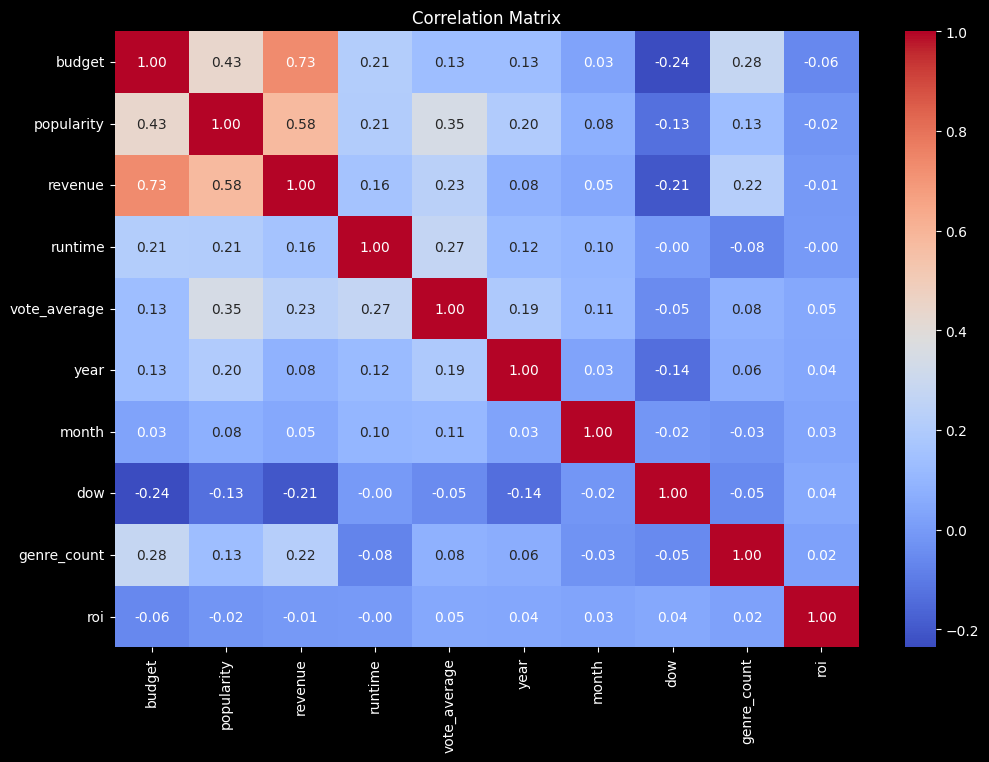

In [191]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [202]:
other = pd.read_csv("Result_4.csv",low_memory=False)

In [203]:
other.shape



(1287, 22)

In [204]:
df.shape

(1243, 21)

In [206]:
other['genre'] = other['genres'].str.extract(r"'name':\s*'([^']+)'")


In [207]:
other

,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,title,vote_average,...,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country,genres,genre
0,150000000,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036,157,Harry Potter and the Goblet of Fire,7.801,...,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Adventure
1,180000000,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115,143,"The Chronicles of Narnia: The Lion, the Witch ...",7.137,...,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",Adventure
2,75000000,['US'],en,Madagascar,14.6773,2005-05-25,542064525,86,Madagascar,6.919,...,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",Family
3,130000000,"['US', 'GB']",en,Kingdom of Heaven,13.3602,2005-05-03,218366336,144,Kingdom of Heaven,7.013,...,1,5,18.683045,19.201685,1.679741,Scott Free Productions,Orlando Bloom,Germany,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",Drama
4,207000000,['US'],en,King Kong,16.8179,2005-12-12,562363449,188,King Kong,6.887,...,0,3,19.148229,20.147659,2.716732,Universal Pictures,Naomi Watts,New Zealand,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,10000000,"['DK', 'FR', 'DE', 'NL']",nl,Pandabeer in Afrika,6.6806,2024-03-15,5514627,94,Panda Bear in Africa,7.100,...,4,4,16.118096,15.522915,0.551463,Cool Beans,Yootha Wong-Loi-Sing,Denmark,NaN,NaN
1283,5400000,['ES'],es,El correo,7.1623,2024-01-19,1751343,102,The Courier,6.437,...,4,2,15.501910,14.375894,0.324323,Vaca Films,Arón Piper,Belgium,NaN,NaN
1284,25600000,['ES'],es,Guardiana de dragones (Dragonkeeper),6.2878,2024-04-11,6206231,99,Dragonkeeper,7.700,...,3,5,17.058103,15.641065,0.242431,Movistar Plus+,Mario Gas,China,NaN,NaN
1285,50000000,['US'],en,Cabrini,5.7988,2024-03-07,20592796,142,Cabrini,7.800,...,3,2,17.727534,16.840452,0.411856,Santa Fe Films,David Morse,Italy,NaN,NaN


In [208]:
other.drop(columns=['genres'], inplace=True)

In [210]:
other

,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,title,vote_average,...,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country,genre
0,150000000,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036,157,Harry Potter and the Goblet of Fire,7.801,...,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom,Adventure
1,180000000,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115,143,"The Chronicles of Narnia: The Lion, the Witch ...",7.137,...,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom,Adventure
2,75000000,['US'],en,Madagascar,14.6773,2005-05-25,542064525,86,Madagascar,6.919,...,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America,Family
3,130000000,"['US', 'GB']",en,Kingdom of Heaven,13.3602,2005-05-03,218366336,144,Kingdom of Heaven,7.013,...,5,1,5,18.683045,19.201685,1.679741,Scott Free Productions,Orlando Bloom,Germany,Drama
4,207000000,['US'],en,King Kong,16.8179,2005-12-12,562363449,188,King Kong,6.887,...,12,0,3,19.148229,20.147659,2.716732,Universal Pictures,Naomi Watts,New Zealand,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,10000000,"['DK', 'FR', 'DE', 'NL']",nl,Pandabeer in Afrika,6.6806,2024-03-15,5514627,94,Panda Bear in Africa,7.100,...,3,4,4,16.118096,15.522915,0.551463,Cool Beans,Yootha Wong-Loi-Sing,Denmark,NaN
1283,5400000,['ES'],es,El correo,7.1623,2024-01-19,1751343,102,The Courier,6.437,...,1,4,2,15.501910,14.375894,0.324323,Vaca Films,Arón Piper,Belgium,NaN
1284,25600000,['ES'],es,Guardiana de dragones (Dragonkeeper),6.2878,2024-04-11,6206231,99,Dragonkeeper,7.700,...,4,3,5,17.058103,15.641065,0.242431,Movistar Plus+,Mario Gas,China,NaN
1285,50000000,['US'],en,Cabrini,5.7988,2024-03-07,20592796,142,Cabrini,7.800,...,3,3,2,17.727534,16.840452,0.411856,Santa Fe Films,David Morse,Italy,NaN


In [213]:
other.to_csv('Final_data.csv', index=False)

In [215]:
other.columns

Index(['budget', 'origin_country', 'original_language', 'original_title',
       'popularity', 'release_date', 'revenue', 'runtime', 'title',
       'vote_average', 'vote_count', 'year', 'month', 'dow', 'genre_count',
       'log_budget', 'log_revenue', 'roi', 'production_company',
       'original_name', 'production_country', 'genre'],
      dtype='object')

In [216]:
dff=other.copy()

In [217]:
dff

,budget,origin_country,original_language,original_title,popularity,release_date,revenue,runtime,title,vote_average,...,month,dow,genre_count,log_budget,log_revenue,roi,production_company,original_name,production_country,genre
0,150000000,['GB'],en,Harry Potter and the Goblet of Fire,21.5325,2005-11-16,895921036,157,Harry Potter and the Goblet of Fire,7.801,...,11,2,2,18.826146,20.613363,5.972807,Warner Bros. Pictures,Daniel Radcliffe,United Kingdom,Adventure
1,180000000,"['US', 'GB']",en,"The Chronicles of Narnia: The Lion, the Witch ...",19.2598,2005-12-07,745013115,143,"The Chronicles of Narnia: The Lion, the Witch ...",7.137,...,12,2,3,19.008467,20.428912,4.138962,Walt Disney Pictures,William Moseley,United Kingdom,Adventure
2,75000000,['US'],en,Madagascar,14.6773,2005-05-25,542064525,86,Madagascar,6.919,...,5,2,4,18.132999,20.110896,7.227527,Pacific Data Images,Ben Stiller,United States of America,Family
3,130000000,"['US', 'GB']",en,Kingdom of Heaven,13.3602,2005-05-03,218366336,144,Kingdom of Heaven,7.013,...,5,1,5,18.683045,19.201685,1.679741,Scott Free Productions,Orlando Bloom,Germany,Drama
4,207000000,['US'],en,King Kong,16.8179,2005-12-12,562363449,188,King Kong,6.887,...,12,0,3,19.148229,20.147659,2.716732,Universal Pictures,Naomi Watts,New Zealand,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,10000000,"['DK', 'FR', 'DE', 'NL']",nl,Pandabeer in Afrika,6.6806,2024-03-15,5514627,94,Panda Bear in Africa,7.100,...,3,4,4,16.118096,15.522915,0.551463,Cool Beans,Yootha Wong-Loi-Sing,Denmark,NaN
1283,5400000,['ES'],es,El correo,7.1623,2024-01-19,1751343,102,The Courier,6.437,...,1,4,2,15.501910,14.375894,0.324323,Vaca Films,Arón Piper,Belgium,NaN
1284,25600000,['ES'],es,Guardiana de dragones (Dragonkeeper),6.2878,2024-04-11,6206231,99,Dragonkeeper,7.700,...,4,3,5,17.058103,15.641065,0.242431,Movistar Plus+,Mario Gas,China,NaN
1285,50000000,['US'],en,Cabrini,5.7988,2024-03-07,20592796,142,Cabrini,7.800,...,3,3,2,17.727534,16.840452,0.411856,Santa Fe Films,David Morse,Italy,NaN


In [218]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# assuming dff is already created as df.copy()

dff['release_date'] = pd.to_datetime(dff['release_date'])
dff['year'] = dff['release_date'].dt.year
dff['month'] = dff['release_date'].dt.month
dff['day_name'] = dff['release_date'].dt.day_name()

# keep only valid movies
dff = dff[(dff['budget'] > 0) & (dff['revenue'] > 0)]

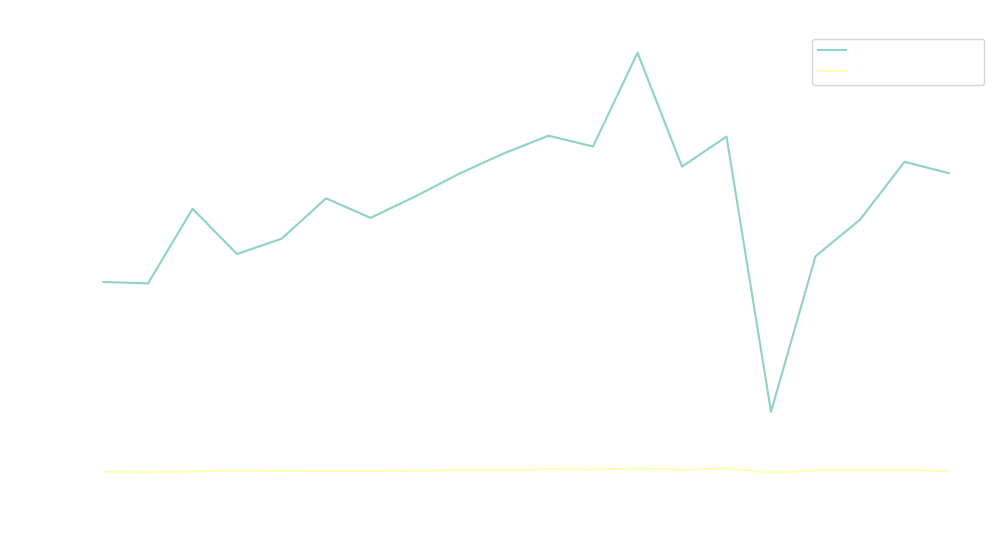

In [219]:
year_group = dff.groupby('year')['revenue'].agg(['sum','mean'])

plt.figure(figsize=(12,6))
plt.plot(year_group.index, year_group['sum'], label='Total Revenue')
plt.plot(year_group.index, year_group['mean'], label='Average Revenue')
plt.xlabel('Release Year')
plt.ylabel('Revenue (USD)')
plt.title('Total and Average Revenue per Year')
plt.legend()
plt.show()


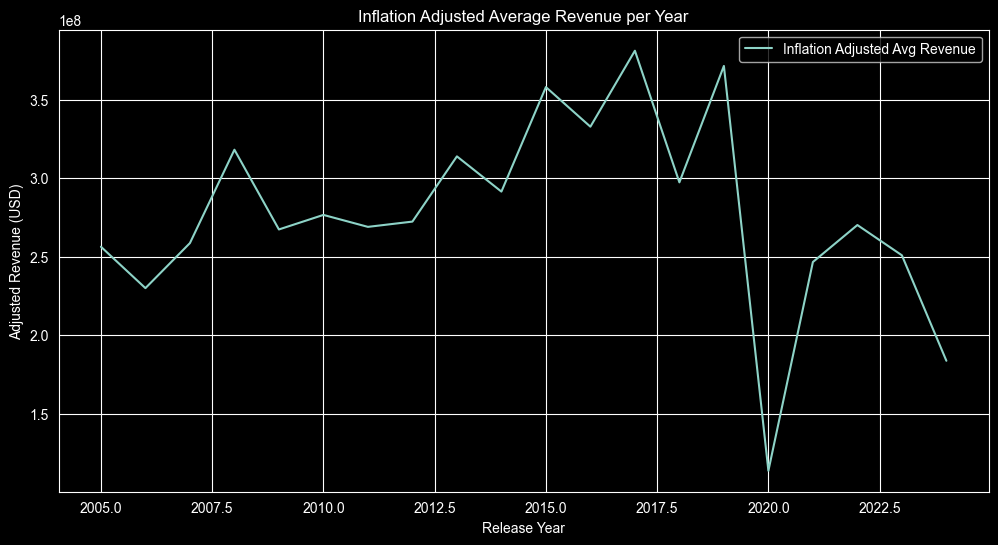

In [220]:
current_year = 2024
dff['adj_revenue'] = dff['revenue'] * (1.025 ** (current_year - dff['year']))

adj_group = dff.groupby('year')['adj_revenue'].mean()

plt.figure(figsize=(12,6))
plt.plot(adj_group.index, adj_group.values, label='Inflation Adjusted Avg Revenue')
plt.xlabel('Release Year')
plt.ylabel('Adjusted Revenue (USD)')
plt.title('Inflation Adjusted Average Revenue per Year')
plt.legend()
plt.show()


In [221]:
"""start here main graphs"""

'start here main graphs'

In [225]:
import plotly.express as px
import plotly.graph_objects as go

plotly_template = "plotly_white"


In [226]:
year_total = dff.groupby('year')['revenue'].sum().reset_index()
year_total['revenue_billion'] = year_total['revenue'] / 1e9

fig = px.line(
    year_total,
    x='year',
    y='revenue_billion',
    markers=True,
    title='Total Box Office Revenue by Release Year',
    labels={'year':'Release Year', 'revenue_billion':'Total Revenue (Billion USD)'},
    template=plotly_template
)

fig.show()


In [227]:
year_avg = dff.groupby('year')['revenue'].mean().reset_index()
year_avg['revenue_million'] = year_avg['revenue'] / 1e6

fig = px.line(
    year_avg,
    x='year',
    y='revenue_million',
    markers=True,
    title='Average Movie Revenue by Year',
    labels={'year':'Release Year', 'revenue_million':'Average Revenue (Million USD)'},
    template=plotly_template
)

fig.show()


In [229]:
current_year = 2025
dff['adj_revenue'] = dff['revenue'] * (1.025 ** (current_year - dff['year']))

adj = dff.groupby('year')['adj_revenue'].mean().reset_index()
adj['adj_million'] = adj['adj_revenue'] / 1e6

fig = px.line(
    adj,
    x='year',
    y='adj_million',
    markers=True,
    title='Inflation Adjusted Average Revenue per Year',
    labels={'year':'Release Year', 'adj_million':'Adjusted Revenue (Million USD)'},
    template=plotly_template
)

fig.show()


In [232]:
top_movies = (
    dff.sort_values('revenue', ascending=False)
       .groupby('year')
       .head(1)
)

fig = px.bar(
    top_movies,
    x='year',
    y='revenue',
    color='title',   # legend = movie name
    title='Highest Grossing Movie per Year',
    labels={
        'year': 'Release Year',
        'revenue': 'Revenue (USD)',
        'title': 'Movie'
    },
    template='plotly_white'
)

fig.update_layout(
    legend_title_text='Movie',
    legend=dict(orientation="h", y=-0.2)
)

fig.show()


In [231]:
actor_year = dff.groupby(['year','original_name'])['revenue'].sum().reset_index()
top_actor = actor_year.sort_values('revenue', ascending=False).groupby('year').head(1)

fig = px.bar(
    top_actor,
    x='year',
    y='revenue',
    color='original_name',
    title='Highest Grossing Actor per Year',
    labels={'year':'Year', 'revenue':'Revenue (USD)', 'original_name':'Actor'},
    template=plotly_template
)

fig.show()


In [244]:
"""top_actors = dff.groupby('original_name')['revenue'].sum().nlargest(10).index
temp = dff[dff['original_name'].isin(top_actors)]

actor_trend = temp.groupby(['year','original_name'])['revenue'].mean().reset_index()

fig = px.line(
    actor_trend,
    x='year',
    y='revenue',
    color='original_name',
    markers=True,
    title='Average Revenue Trend of Top 10 Actors',
    labels={'year':'Year', 'revenue':'Average Revenue (USD)', 'original_name':'Actor'},
    template=plotly_template
)

fig.show()
"""
# Top 10 actors by total revenue
top_actors = (
    dff.groupby('original_name')['revenue']
       .sum()
       .nlargest(5)
       .index
)

actor_data = dff[dff['original_name'].isin(top_actors)]

actor_trend = (
    actor_data.groupby(['year','original_name'])['revenue']
              .mean()
              .reset_index()
              .sort_values('year')
)

# Smooth using rolling average (window=3 years)
actor_trend['smooth_revenue'] = (
    actor_trend.groupby('original_name')['revenue']
               .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

fig = px.line(
    actor_trend,
    x='year',
    y='smooth_revenue',
    color='original_name',
    markers=True,
    title=' Average Revenue Trend of Top 5 Actors',
    labels={
        'year': 'Release Year',
        'smooth_revenue': ' Average Revenue (USD)',
        'original_name': 'Actor'
    },
    template='plotly_white'
)

fig.update_layout(legend_title_text='Actor')

fig.show()


In [236]:
month_rev = dff.groupby('month')['revenue'].mean().reset_index()

fig = px.bar(
    month_rev,
    x='month',
    y='revenue',
    title='Average Revenue by Release Month',
    labels={'month':'Month', 'revenue':'Average Revenue (USD)'},
    template=plotly_template
)

fig.show()


In [237]:
dow_rev = dff.groupby('day_name')['revenue'].mean().reset_index()

fig = px.bar(
    dow_rev,
    x='day_name',
    y='revenue',
    title='Average Revenue by Day of Week',
    labels={'day_name':'Day of Week', 'revenue':'Average Revenue (USD)'},
    template=plotly_template
)

fig.show()


In [246]:
# Find top 5 genres by total revenue
top_genres = (
    dff.groupby('genre')['revenue']
       .sum()
       .nlargest(5)
       .index
)

genre_year = (
    dff[dff['genre'].isin(top_genres)]
       .groupby(['year','genre'])['revenue']
       .mean()
       .reset_index()
       .sort_values('year')
)

# Smooth per genre
genre_year['smooth_revenue'] = (
    genre_year.groupby('genre')['revenue']
              .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

fig = px.line(
    genre_year,
    x='year',
    y='smooth_revenue',
    color='genre',
    markers=True,
    title=' Revenue Trend of Top 5 Genres',
    labels={
        'year': 'Release Year',
        'smooth_revenue': ' Average Revenue (USD)',
        'genre': 'Genre'
    },
    template='plotly_white',
    height=600
)

fig.update_layout(legend_title_text='Genre')

fig.show()


In [252]:
"""fig = px.scatter(
    dff,
    x='budget',
    y='revenue',
    color='genre',
    log_x=True,
    log_y=True,
    title='Log-Scaled Revenue vs Budget by Genre',
    labels={
        'budget': 'Budget (Log USD)',
        'revenue': 'Revenue (Log USD)',
        'genre': 'Genre'
    },
    template='plotly_white',
    height=600
)

fig.update_layout(legend_title_text='Genre')

fig.show()
"""
# Create readable budget bins
bins = [0, 10e6, 30e6, 60e6, 100e6, 200e6, 500e6]
labels = ['0-10M', '10-30M', '30-60M', '60-100M', '100-200M', '200M+']

dff['budget_bin'] = pd.cut(dff['budget'], bins=bins, labels=labels)

budget_story = (
    dff.groupby('budget_bin')['revenue']
       .mean()
       .reset_index()
)

fig = px.bar(
    budget_story,
    x='budget_bin',
    y='revenue',
    color='budget_bin',
    title='How Revenue Changes Across Budget Ranges',
    labels={
        'budget_bin': 'Budget Range (USD)',
        'revenue': 'Average Revenue (USD)'
    },
    template='plotly_white',
    height=600
)

fig.update_layout(showlegend=False)

fig.show()


/var/folders/zl/_d0xxmj90xs16fq2fqxqb_fw0000gn/T/ipykernel_6027/3884860758.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [253]:
# Meaningful runtime groups
bins = [0, 90, 110, 130, 150, 300]
labels = ['<90 min', '90–110', '110–130', '130–150', '150+']

dff['runtime_group'] = pd.cut(dff['runtime'], bins=bins, labels=labels)

runtime_story = (
    dff.groupby('runtime_group')['revenue']
       .mean()
       .reset_index()
)

fig = px.bar(
    runtime_story,
    x='runtime_group',
    y='revenue',
    color='runtime_group',
    title='Longer Movies Consistently Earn More Revenue',
    labels={
        'runtime_group': 'Runtime Group',
        'revenue': 'Average Revenue (USD)'
    },
    template='plotly_white',
    height=700
)

fig.update_layout(showlegend=False)
fig.show()


/var/folders/zl/_d0xxmj90xs16fq2fqxqb_fw0000gn/T/ipykernel_6027/2895957832.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [254]:
top5 = dff.groupby('origin_country')['revenue'].mean().nlargest(5).index

dff['country_group'] = dff['origin_country'].apply(
    lambda x: x if x in top5 else 'Rest of World'
)

country_story = (
    dff.groupby('country_group')['revenue']
       .mean()
       .reset_index()
       .sort_values('revenue', ascending=False)
)

fig = px.bar(
    country_story,
    x='country_group',
    y='revenue',
    color='country_group',
    title='Revenue Dominance by Top Countries vs Rest of World',
    labels={
        'country_group': 'Country Group',
        'revenue': 'Average Revenue (USD)'
    },
    template='plotly_white',
    height=700
)

fig.update_layout(showlegend=False)
fig.show()


In [255]:
bins = [0, 10e6, 30e6, 60e6, 100e6, 200e6, 500e6]
labels = ['0-10M', '10-30M', '30-60M', '60-100M', '100-200M', '200M+']

dff['budget_group'] = pd.cut(dff['budget'], bins=bins, labels=labels)

roi_story = (
    dff.groupby('budget_group')['roi']
       .mean()
       .reset_index()
)

fig = px.bar(
    roi_story,
    x='budget_group',
    y='roi',
    color='budget_group',
    title='Smaller Budgets Deliver Higher ROI',
    labels={
        'budget_group': 'Budget Range (USD)',
        'roi': 'Average ROI'
    },
    template='plotly_white',
    height=700
)

fig.update_layout(showlegend=False)
fig.show()


/var/folders/zl/_d0xxmj90xs16fq2fqxqb_fw0000gn/T/ipykernel_6027/601620719.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

